<a href="https://colab.research.google.com/github/geraldmc/torch-draft-final_project/blob/main/load_deepweeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Welcome to the **[Project Page ...](https://)**

This notebook is associated with the project submission of MOHAMMED RASHED and GERALD MCCOLLAM and for the class `EN.525.733.8VL.SP22 Deep Learning for Computer Vision`. Our semester project is [Weed Object Detection](https://).

This notebook may be executed by pressing ▶️ block-by-block, without adjusting `args` inputs. It may also be executed with `Run all` under ` Runtime` in the menu.

<hr>

### Download the code from Github

In [1]:
import os

if os.path.isfile("../main.zip"):
  print ('Have already downloaded the project file, continuing...')
  print()
else:
  print ('Downloading file...')
  ! wget https://github.com/geraldmc/torch-draft-final_project/archive/refs/heads/main.zip
  ! unzip -qq main.zip
  %cd torch-draft-final_project-main

--2022-03-29 22:06:09--  https://github.com/geraldmc/torch-draft-final_project/archive/refs/heads/main.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/geraldmc/torch-draft-final_project/zip/refs/heads/main [following]
--2022-03-29 22:06:09--  https://codeload.github.com/geraldmc/torch-draft-final_project/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 52.193.111.178
Connecting to codeload.github.com (codeload.github.com)|52.193.111.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [ <=>                ] 526.76K  2.65MB/s    in 0.2s    

2022-03-29 22:06:11 (2.65 MB/s) - ‘main.zip’ saved [539403]

/content/torch-draft-final_project-main


### Download the dataset from Google Drive

The project dataset and models are available on the DeepWeeds Github. There are two options for getting these into our Colab Notebook environment - 

* Download from Github as two zipped files ([dataset link here](https://drive.google.com/file/d/1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj), [models file link here](https://drive.google.com/file/d/1MRbN5hXOTYnw7-71K-2vjY01uJ9GkQM5)) and upload these to Google Drive, then mount Google Drive on Colab to access the uploaded dataset and models. 
* Use the [Drive API](https://) to download the dataset and models into the Colab Notebook. 

In [2]:
# Import local libs in a try block
try:
  import conf.params as params
except ImportError:
  pass

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
print("Downloading DeepWeeds images to " + params.IMG_ZIP_FILE)
!cp '{params.GD_ZIP_IMG}' '{params.IMG_ZIP_FILE}'
print()
!ls -lart {params.IMG_ZIP_FILE}

Mounted at /content/gdrive

-rw------- 1 root root 491516047 Mar 29 22:07 /content/torch-draft-final_project-main/data/images.zip


In [4]:
from zipfile import ZipFile
print("Unzipping DeepWeeds images into " + params.IMG_DIRECTORY)

with ZipFile(params.IMG_ZIP_FILE, "r") as zip_ref:
    zip_ref.extractall(params.IMG_DIRECTORY)

img_list=os.listdir(params.IMG_DIRECTORY)
print(len(img_list))
img_list[0:5]

Unzipping DeepWeeds images into /content/torch-draft-final_project-main/data/images
17509


['20180105-100126-2.jpg',
 '20170126-100535-0.jpg',
 '20170217-115626-0.jpg',
 '20170729-091840-1.jpg',
 '20170304-132112-0.jpg']

### Download and instantiate Imagenet-trained resnet50 model for Pytorch.

*Author: Pytorch Team*

**Deep residual networks pre-trained on ImageNet**

<img src="https://pytorch.org/assets/images/resnet.png" alt="alt" width="50%"/>

Pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [ ]:
import torch
resnet50_torch = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

In [ ]:
# Sample load and execution
from PIL import Image
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def single_image_loader(img):
    image = Image.open(img)
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch, as expected
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
    return image, input_batch

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    resnet50_torch.to('cuda')

filename = params.IMG_DIRECTORY + '/20180105-100126-2.jpg'
#!ls {filename}
image, input_batch = single_image_loader(filename)
display(image)

with torch.no_grad():
    output = resnet50_torch(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
# print(output[0]) # output has unnormalized scores
# To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

### Alter the fully-connected output layer to match the number of classes.

In [ ]:
import torch.nn as nn
# Get number of parameters going into the last fc layer.
num_final_in = resnet50_torch.fc.in_features

# The final layer of the model is model.fc. We can overwrite this 
# to have the output = number of classes that we want. We want 9 classes.
NUM_CLASSES = 9
resnet50_torch.fc = nn.Linear(num_final_in, NUM_CLASSES)

In [ ]:
from torchvision import models
from torchsummary import summary

INPUT_SHAPE = (3, 224, 224)
summary(resnet50_torch.cuda(), (INPUT_SHAPE)) # after changing size of output fc layer

### Download a pre-trained InceptionV3 model from Pytorch

*Author: Pytorch Team*

<img src="https://pytorch.org/assets/images/inception_v3.png" alt="alt" width="33%"/>

Pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 299. The images have to be loaded in to a range of [0, 1] then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [ ]:
inception_v3_torch = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

### Get the Labels

In [7]:
LABEL_PATH = os.path.join(params.DATA_PATH, 'labels')
!ls {LABEL_PATH}

labels.csv	  test_subset3.csv   train_subset2.csv	val_subset1.csv
test_subset0.csv  test_subset4.csv   train_subset3.csv	val_subset2.csv
test_subset1.csv  train_subset0.csv  train_subset4.csv	val_subset3.csv
test_subset2.csv  train_subset1.csv  val_subset0.csv	val_subset4.csv


In [8]:
import pandas as pd
label_df = pd.read_csv(os.path.join(LABEL_PATH, 'labels.csv'))
label_df

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [9]:
label0 = label_df[label_df["Label"] == 0]
label1 = label_df[label_df["Label"] == 1]
label2 = label_df[label_df["Label"] == 2]
label3 = label_df[label_df["Label"] == 3]
label4 = label_df[label_df["Label"] == 4]
label5 = label_df[label_df["Label"] == 5]
label6 = label_df[label_df["Label"] == 6]
label7 = label_df[label_df["Label"] == 7]
label8 = label_df[label_df["Label"] == 8]

len_all_weeds = len(label0) + len(label1) + \
len(label2) + len(label3) + len(label4) + \
len(label5) + len(label6) + len(label7)

print('Combined weed samples={}. Negative samples={}.'.format(
    len_all_weeds, len(label8) ) )

Combined weed samples=8403. Negative samples=9106.


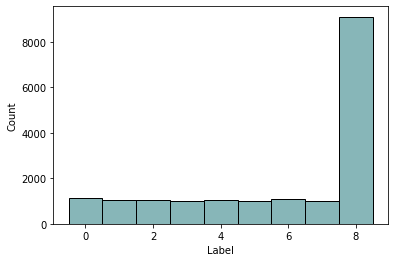

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(label_df['Label'], bins=8, discrete=True, color="cadetblue")
None

In [11]:
label0

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
6160,20171025-082743-1.jpg,0,Chinee apple
6162,20171025-082800-1.jpg,0,Chinee apple
6163,20171025-082818-1.jpg,0,Chinee apple
6165,20171025-082836-1.jpg,0,Chinee apple


In [ ]:
# Prepare training, validation and testing labels
train_label_file = "{}/train_subset{}.csv".format(LABEL_PATH, 0)
test_label_file = "{}/test_subset{}.csv".format(LABEL_PATH, 0)
val_label_file = "{}/val_subset{}.csv".format(LABEL_PATH, 0)

train_df = pd.read_csv(train_label_file)
test_df = pd.read_csv(test_label_file)
val_df = pd.read_csv(val_label_file)

train_count = train_df.shape[0]
val_count = val_df.shape[0]
test_count = test_df.shape[0]

In [ ]:
print('Train={}, Val={}, Test={}'.format(train_count, val_count, test_count))

In [ ]:
''' GUTTER ------ 

### Download the models from Google Drive

print("Downloading DeepWeeds model file to " + params.MODEL_ZIP_FILE)
!cp '{params.GD_ZIP_MODEL}' {params.MODEL_ZIP_FILE}
print()
!ls -lart {params.MODEL_ZIP_FILE}


print("Unzipping DeepWeeds model files into " + params.MODEL_DIRECTORY)
with ZipFile(params.MODEL_ZIP_FILE, "r") as zip_ref:
    zip_ref.extractall(params.MODEL_DIRECTORY)

!ls -lart {params.MODEL_DIRECTORY}

'''